In [1]:
import numpy as np
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.display import Audio,Image
from PIL import Image as PIL_Image
import multiprocessing
from joblib import Parallel,delayed

import os,sys
os.system("taskset -p 0xff %d" % os.getpid())
sys.path.append(os.path.expanduser('~')+'/audio_class/python')
sys.path.append('../../audio_class/python')
import audio_class
import ridgeDTW
import delay2loc
import audio_loc

#%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
DATAROOT = './BBSPjun5_13/'

In [3]:
########## Work on a single recording first
fs,data = audio_class.readSegment(DATAROOT+'day2-1370485107.wav')
NCh,NDat = np.shape(data)

In [4]:
print('fs = %s' % fs)
print('NCh = %s, NDat = %s' % (NCh,NDat))
Audio(data[0,:],rate=fs)

fs = 44100
NCh = 8, NDat = 2646000


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [5]:
# hierarchical processing
tHieBlk=[0.032,0.064,0.128,0.256,2.]
tHieInc=[0.004,0.008,0.016,0.032,1.]
hRidges,hSpecs = audio_loc.hieProc(data,fs,tHieBlk,tHieInc)

True
n1 = 2583, n2 = 3445


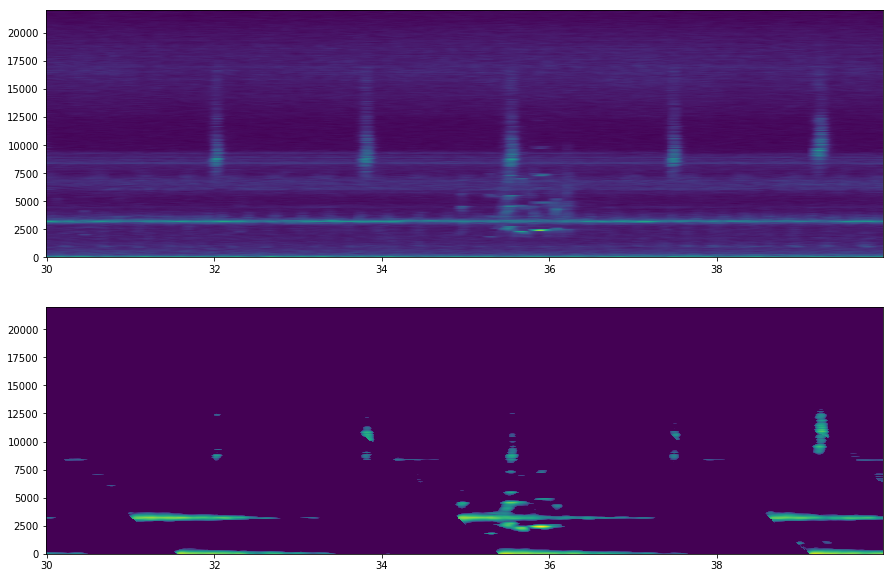

In [6]:
level = 2
chIdx = 7
S,F,T,tHBlk,tHInc = hSpecs[level][chIdx]
X = hRidges[level][chIdx]
print(tHInc == T[1]-T[0])
n1 = int(30/tHInc)
n2 = int(40/tHInc)
print('n1 = %s, n2 = %s' % (n1,n2))

plt.figure(figsize=(15,10))
plt.subplot(211)
plt.pcolormesh(T[n1:n2],F,np.sqrt(S[:,n1:n2]))
plt.subplot(212)
plt.pcolormesh(T[n1:n2],F,np.sqrt(X[:,n1:n2]))

In [7]:
nBlk = int(2./tHInc)
nInc = int(1./tHInc)

XSegs = [None]*NCh
for k in range(NCh):
    X = hRidges[level][k]
    XSegs[k] = audio_loc.segment(X,nBlk,nInc)
XSegs = np.array(XSegs)
XSegs = np.swapaxes(XSegs,0,1)
print(np.shape(XSegs))

(61, 8, 512, 172)


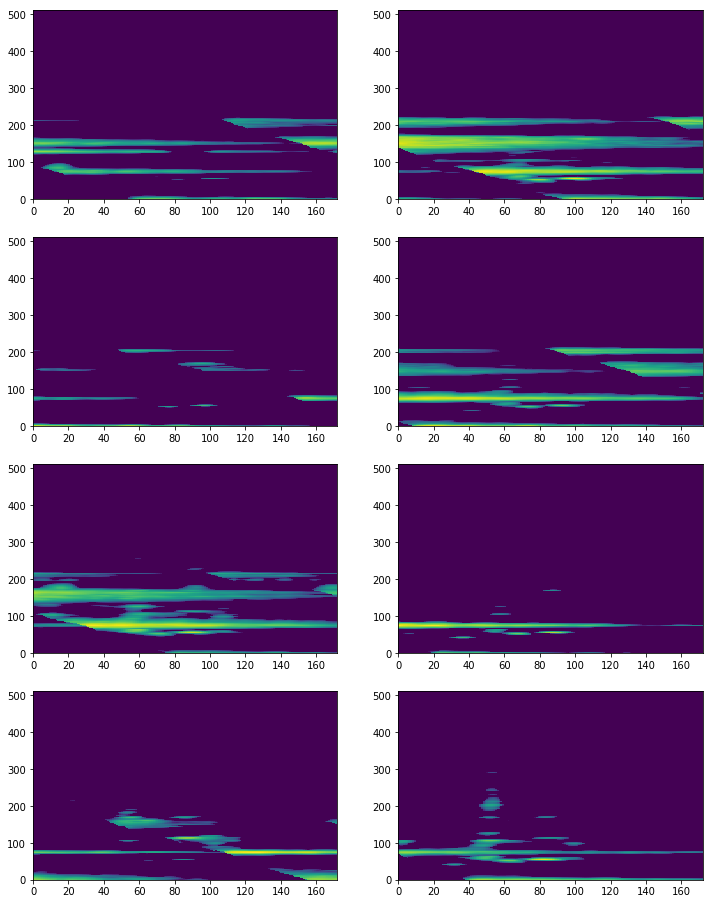

In [8]:
plt.figure(figsize=(12,16))
for k in range(NCh):
    plt.subplot(NCh//2,2,1+k)
    plt.pcolormesh(np.sqrt(XSegs[35,k,:,:]))

(512, 172)


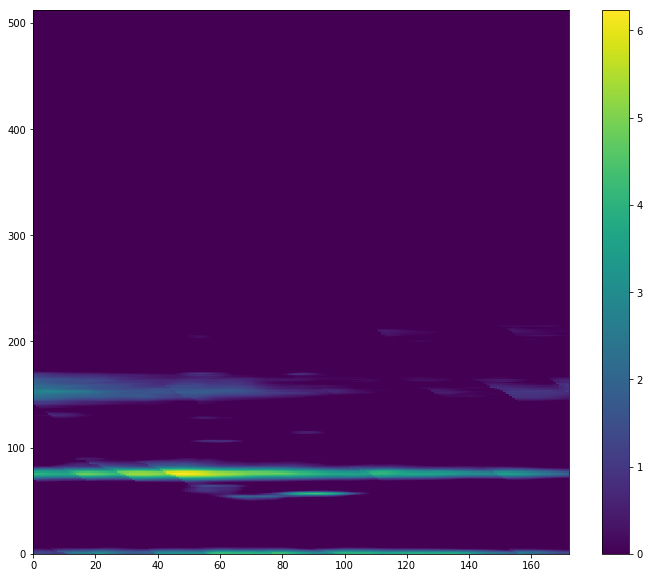

In [9]:
XSegAvg = np.mean(XSegs[35,:,:,:],axis=0)
plt.figure(figsize=(12,10))
XSegAvg = XSegAvg-np.percentile(XSegAvg,90)
XSegAvg[XSegAvg < 0] = 0.
print(np.shape(XSegAvg))
plt.pcolormesh(XSegAvg)
plt.colorbar()

In [19]:
masks = audio_loc.labelObjects(XSegAvg)
print(len(masks))

18


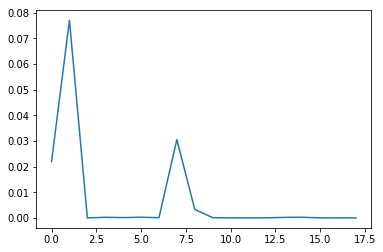

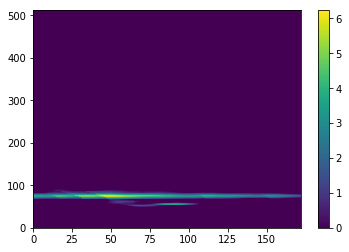

In [33]:
sm = np.zeros(len(masks))
for k in range(len(masks)):
    sm[k] = np.mean(masks[k])
plt.figure()
plt.plot(sm)
plt.figure()
plt.pcolormesh(masks[1])
plt.colorbar()

In [ ]:
# measure the delays in matrix form
meas_delayMat = np.zeros((NCh,NCh))
mid = n2-n1
tInc = T[1]-T[0]
print('tInc = %s' % tInc)
print('tBlk = %s' % (len(F)*2/fs))
for k in range(NCh):
    for l in range(k+1,NCh):
        '''
        corr = sp.signal.correlate(out[k][n1:n2],out[l][n1:n2])
        print(np.argmax(corr))
        plt.figure()
        plt.plot(corr)
        '''
        meas_delayMat[k,l] = meas_delayMat[l,k] = \
            tInc*(np.argmax(sp.signal.correlate(out[k][n1:n2],out[l][n1:n2]))-mid)

In [ ]:
print(meas_delayMat)

In [ ]:
# load mics' locations
micsloc = []
with open('micloc1.csv','r') as fid:
    for lines in fid:
        tokens = lines.split(',')
        micsloc.append([float(tokens[0]),float(tokens[1]),float(tokens[2])])
micsloc = np.array(micsloc)
print('micsloc = %s' % micsloc)

In [ ]:
# localize the source from the given delay measurement 
loc,err,grad = delay2loc.delay2loc_grad(micsloc,meas_delayMat)

In [ ]:
# generates 3D images of our environment
# refs: TRTimage.py from mpop
def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h, 4 ) # quick reshape
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf
# refs: http://stackoverflow.com/questions/11140163/python-matplotlib-plotting-a-3d-cube-a-sphere-and-a-vector
def draw_ball(axes,cen,rad):
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = rad[0]*np.cos(u)*np.sin(v)
    y = rad[1]*np.sin(u)*np.sin(v)
    z = rad[2]*np.cos(v)
    axes.plot_wireframe(cen[0]+x,cen[1]+y,cen[2]+z,color="r")

fig = plt.figure(figsize=(8,8))
axes = fig.gca(projection='3d')
#axes.set_aspect("equal")

axes.scatter(micsloc[:,0],micsloc[:,1],micsloc[:,2],s=100,c='b')
for k in range(NCh):
    axes.text(micsloc[k,0],micsloc[k,1],micsloc[k,2],'Mic %s' % k,
              fontweight='bold',fontsize='large')

axes.scatter(loc[0],loc[1],loc[2],c='r')
axes.text(loc[0],loc[1],loc[2],'Src',fontweight='bold',fontsize='large')

draw_ball(axes,loc,grad/max(grad))

axes.set_xlabel('X axis (m)')
axes.set_ylabel('Y axis (m)')
axes.set_zlabel('Z axis (m)')

images = []
for angle in range(0,360,1):
    axes.view_init(30, angle)
    imData = fig2data(fig)
    w,h,d = imData.shape
    im = PIL_Image.frombytes('RGBA',(w,h),imData)
    images.append(im)

In [ ]:
# sanity checks
size = fig.get_size_inches()*fig.dpi # size in pixels
size = tuple(size.astype(int))
print(size)
#print('(%s, %s)' % (w,h))
print(size == (w,h))

print(images[0])
plt.figure(figsize=(8,16))
plt.subplot(211)
plt.imshow(images[0])
plt.subplot(212)
plt.imshow(images[10])

In [ ]:
# Animate
gif_pathname = 'images/micsloc_srcloc.gif'
gif = images[0]
gif.info['duration'] = tuple([100]*len(images)) # ms per frame
gif.info['loop'] = 0 # how many times to loop (0=infinite)
gif.save(fp=gif_pathname, format='gif', save_all=True, append_images=images[1:])

# verify that the number of frames in the gif equals the number of image files and durations
print(len(images))
print(PIL_Image.open(gif_pathname).n_frames == len(images))

# might need to refresh the page to reload the image,
# according to https://github.com/jupyter/notebook/issues/1369
Image(url=gif_pathname)

In [ ]:
########## Work on all recordings
for file in os.listdir(DATAROOT):
    print(file)
    fs,data = audio_class.readSegment(DATAROOT+file)
    break